In [50]:
import numpy as np
import pandas as pd
from scipy import optimize
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import analysis_pca
from sklearn import linear_model

Ts = 1000
data_path = r'C:\Users\IBS\Desktop\python_code_N2'
save_path = r'C:\Users\IBS\Desktop\figures'

In [2]:
# Path to your Excel file
SOURCE_DATA_SF3 = 'SupplementaryFigure3.xlsx'

# Read specific sheet and ranges
mf = pd.read_excel(SOURCE_DATA_SF3, sheet_name='Figure S3b,c,d,f', usecols='A:HY', skiprows=2, nrows=502)
pc = pd.read_excel(SOURCE_DATA_SF3, sheet_name='Figure S3b,c,d,f', usecols='HZ:TP', skiprows=2, nrows=502)

In [3]:
# rate is ssc0, drate is wv0
lm_MF = {
    'rate': mf.iloc[:, 0:116].to_numpy().T,
    'drate': mf.iloc[:, 116:232].to_numpy().T,
    'v0': mf.iloc[0, 232],
    'label': 'MF'
}

lm_PC = {
    'rate': pc.iloc[:, 0:151].to_numpy().T,
    'drate': pc.iloc[:, 151:302].to_numpy().T,
    'v0': pc.iloc[0, 302],
    'label': 'PC'
}

# for analyze data
data_mf = lm_MF['rate']
data_pc = lm_PC['rate']

In [4]:
#For FN PCA

import pre_processing

ppss = pre_processing.pre_processing(Ts, data_path, save_path)
[final_cat, data_cat, val_cat, dur_cat, rejectedXY_cat] = ppss.datasorting_orientation(1)

apca = analysis_pca.analysis_pca(Ts, data_cat, save_path)
data_cat_sm = apca.smoothing_data()

In [265]:
# preprocessing

data_fn = np.array(np.concatenate(data_cat_sm, axis = 0))
pFN = data_fn[:,50:550]

pMP = data_mf[:, :500]
pPC = data_pc[:, :500]

pMPC = np.vstack((pMP, pPC))
pMPC = pMPC.T

In [123]:
betas = []
r_2 = []
for a in range(len(pFN)):
    pFN[a] = pFN[a] - np.mean(pFN[a][:100])
    beta, resid = np.linalg.lstsq(pMPC, pFN[a], rcond=None)[:2]
    resid = np.linalg.norm(pMPC @ beta - pFN[a])**2
    r_s = 1 - resid / (pFN[a].size * pFN[a].var())
    betas.append(beta)
    r_2.append(r_s)

betas = np.array(betas)
r_2 = np.array(r_2)

(array([  1.,   2.,   6.,   5.,   4.,  20.,  31.,  37.,  85., 345.]),
 array([0.99784473, 0.99805928, 0.99827383, 0.99848838, 0.99870293,
        0.99891748, 0.99913202, 0.99934657, 0.99956112, 0.99977567,
        0.99999022]),
 <BarContainer object of 10 artists>)

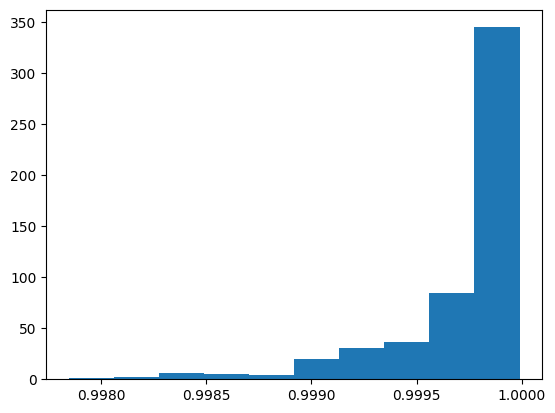

In [7]:
plt.hist(r_2)

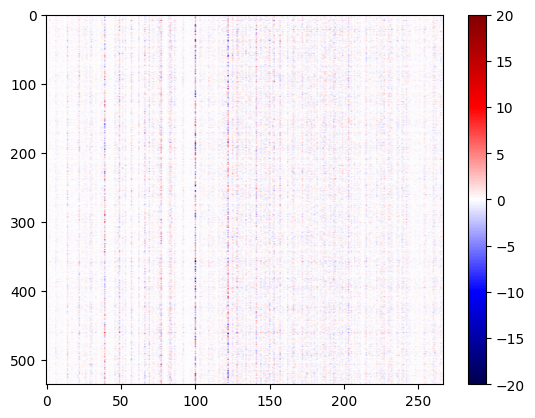

In [136]:
plt.imshow(betas, aspect='auto', cmap='seismic', origin='upper')
plt.clim(-20, 20)
plt.colorbar()

Text(0.5, 1.0, 'FN cell 3, R^2=0.9998784071705843')

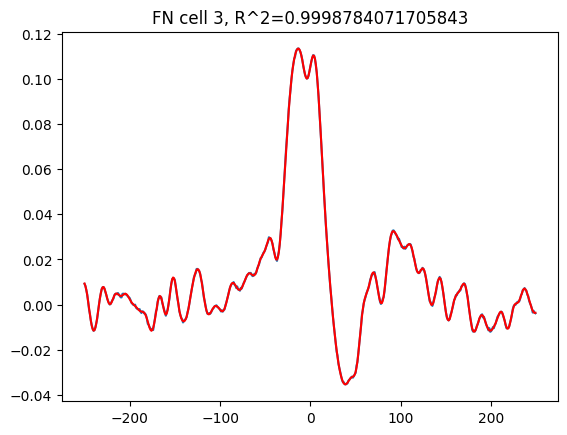

In [126]:
# plotting
t = np.arange(-250,250)

a=2
plt.plot(t, pMPC @ betas[a])
plt.plot(t, pFN[a], 'r')
plt.title(f'FN cell {a+1}, R^2={r_2[a]}')

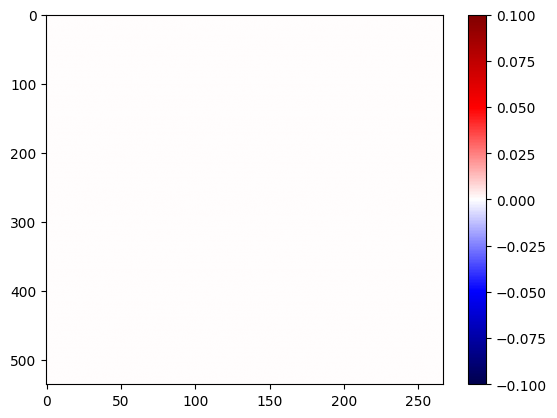

In [132]:
# Lasso
clf = linear_model.MultiTaskLasso(alpha=0.1)
clf.fit(pMPC, pFN.T)
plt.imshow(clf.coef_, aspect='auto', cmap='seismic', origin='upper')
plt.colorbar()

In [ ]:
# plotting
t = np.arange(-250,250)

a=2
plt.plot(t, pMPC @ betas[a])
plt.plot(t, pFN[a], 'r')
plt.title(f'FN cell {a+1}, R^2={r_2[a]}')

In [319]:
# Make MF positive beta , PC beta negative
pMPC = pPC.T

pMPC = pMPC-pMPC.mean(axis=0)[None,:]

if pMPC.shape[1] == pMP.shape[0]:
    lower_bounds = np.zeros(pMP.shape[0])
    upper_bounds = np.tile(np.inf, pMP.shape[0])
elif pMPC.shape[1] == pPC.shape[0]:
    lower_bounds = np.tile(-np.inf, pPC.shape[0])
    upper_bounds = np.zeros(pPC.shape[0])
else:
    lower_bounds = np.concatenate([np.zeros(pMP.shape[0]), np.tile(-np.inf, pPC.shape[0])])
    upper_bounds = np.concatenate([np.tile(np.inf, pMP.shape[0]), np.zeros(pPC.shape[0])])

betas_pn = []
r_2_pn = []
resid_t = []
for a in range(len(pFN)):
    # pFN[a] = pFN[a] - np.mean(pFN[a][:100])
    pFN[a] = pFN[a] - np.mean(pFN[a])
    output = optimize.lsq_linear(pMPC, pFN[a], bounds=(lower_bounds, upper_bounds), max_iter = 400)
    beta = output['x']; temp_var = output['fun'] - np.mean(output['fun'])
    # resid = np.linalg.norm(output['fun']) ** 2
    resid = np.linalg.norm(temp_var) ** 2
    
    r_s = 1 - resid / (pFN[a].size * pFN[a].var())
    betas_pn.append(beta)
    r_2_pn.append(r_s)
    resid_t.append(resid)

if pMPC.shape[1] == pMP.shape[0]:
    betas_pn2 = np.array(betas_pn)
    r_2_pn2 = np.array(r_2_pn)
    resid_t2 = np.array(resid_t)
elif pMPC.shape[1] == pPC.shape[0]:
    betas_pn3 = np.array(betas_pn)
    r_2_pn3 = np.array(r_2_pn)
    resid_t3 = np.array(resid_t)
else:
    betas_pn = np.array(betas_pn)
    r_2_pn = np.array(r_2_pn)
    resid_t = np.array(resid_t)

(array([  1.,   0.,   5.,  12.,  10.,  24.,  26.,  31.,  94., 333.]),
 array([0.79685074, 0.81698512, 0.83711951, 0.85725389, 0.87738827,
        0.89752265, 0.91765704, 0.93779142, 0.9579258 , 0.97806018,
        0.99819457]),
 <BarContainer object of 10 artists>)

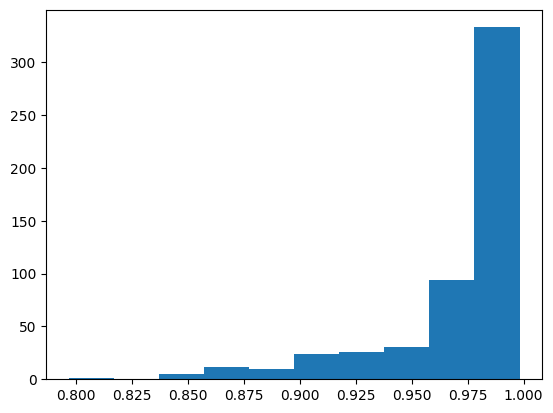

In [330]:
plt.hist(r_2_pn3)

(0.0, 1.0)

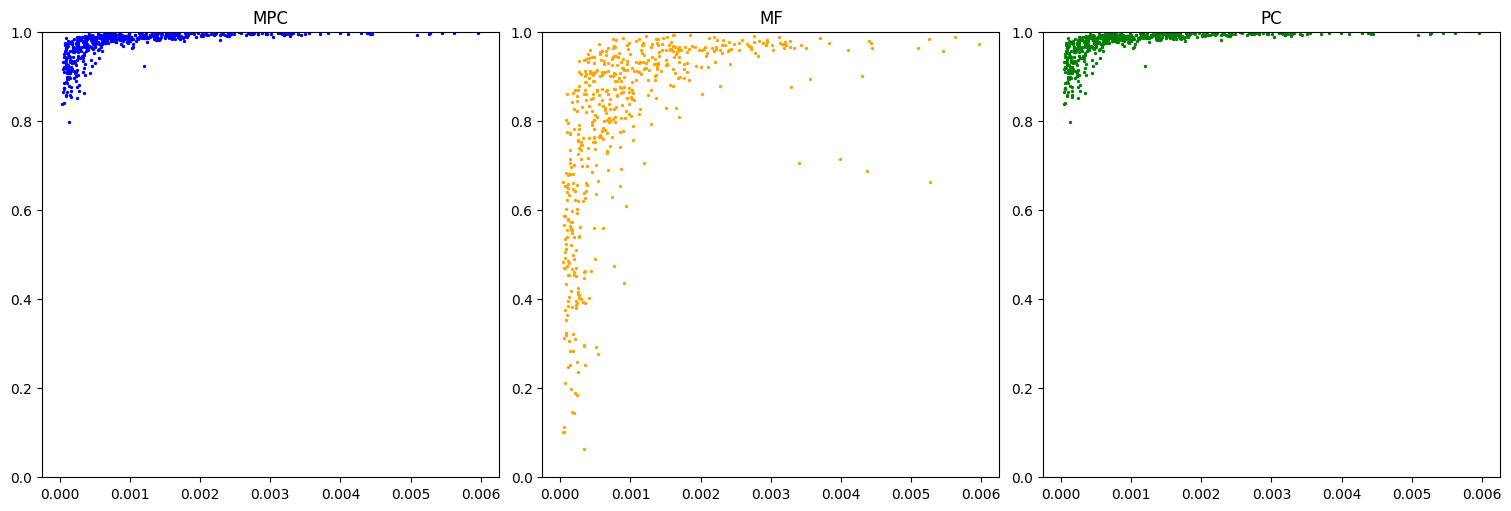

In [349]:
fig = plt.figure(constrained_layout=True,figsize=(15,5))

ax = fig.add_subplot(1, 3, 1)
ax.scatter(pFN.var(axis=1), r_2_pn, 2,'b')
ax.set_title('MPC')
ax.set_ylim(0, 1)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(pFN.var(axis=1), r_2_pn2, 2, 'orange')
ax.set_title('MF')
ax.set_ylim(0, 1)
ax = fig.add_subplot(1, 3, 3)
ax.scatter(pFN.var(axis=1), r_2_pn3, 2, 'g')
ax.set_title('PC')
ax.set_ylim(0, 1)

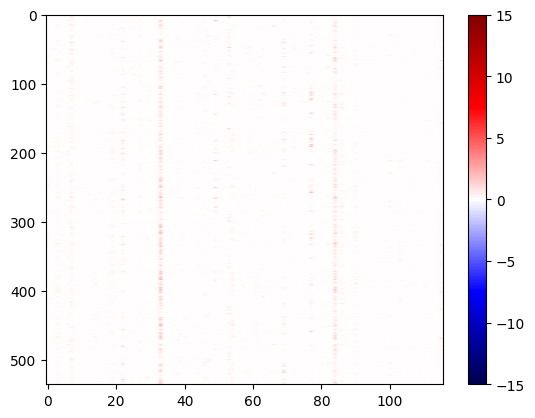

In [318]:
plt.imshow(betas_pn2, aspect='auto', cmap='seismic', origin='upper')
plt.clim(-15, 15)
plt.colorbar()

2.7755575615628914e-15
1.1102230246251565e-16
0.02311594136684477
0.027298979996071084
0.027298979996071084


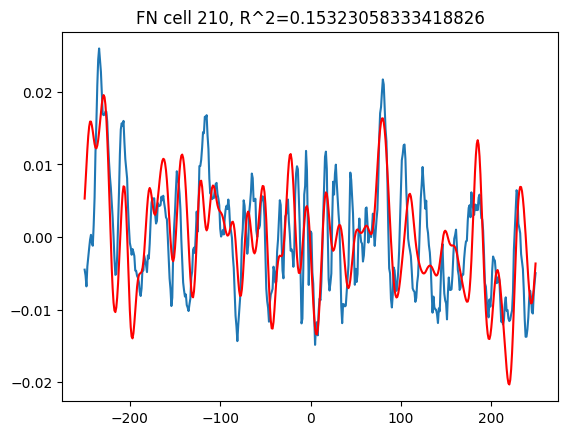

In [314]:
# plotting
t = np.arange(-250,250)

a=209
plt.plot(t, pMPC @ betas_pn[a])
plt.plot(t, pFN[a], 'r')
plt.title(f'FN cell {a+1}, R^2={r_2_pn[a]}')
print(np.mean(pMPC @ betas_pn[a]) * 500)
print(np.mean(pFN[a]) * 500)
print(np.sum((pMPC @ betas_pn[a] - pFN[a]) ** 2))
print(pFN[a].size * pFN[a].var())
print(np.sum((pFN[a] - np.mean(pFN[a])) ** 2))

In [315]:
np.argsort(r_2_pn)

array([290, 209,  89, 312, 311, 190, 360, 446,  94,  23, 276, 257,  22,
       425, 245, 491, 207,  73,  21, 161, 436, 423, 164, 358, 527, 343,
       156, 434, 172,  97,  81, 142, 445, 410, 223, 492, 341, 233, 482,
       432,  92,  75,  27, 503, 159, 298, 496, 274, 140, 302, 494, 513,
       293, 378,  90,  19, 357, 101, 365, 169, 141, 244, 291, 408,  43,
       228, 495, 477,  86,   8, 178,   6, 512,  62, 157, 281,  25, 215,
       483,  34, 226, 348, 231, 418, 416, 475, 379, 224, 427, 177, 367,
       429, 499, 123, 488,  42, 288, 320, 217, 205, 148,  30, 168, 105,
        44, 187, 415, 369,  26, 339, 154, 153, 502, 138, 461, 485,  93,
       300, 295,  33, 214, 282, 219, 507,  14, 176, 147, 152, 284, 130,
       188, 235,  74,  83, 511, 521, 349, 299, 424, 119, 186, 344, 221,
       239, 525, 362, 204, 351, 111,  63, 422, 353,  53,  87, 286, 243,
       109,  18,  39, 405, 366, 220,  88, 139, 406, 531,  80,  58, 296,
       166, 272, 227, 433, 522,  13, 440, 394,  95, 411, 165, 45